In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.bp as bp
import pyeit.eit.greit as greit
import pyeit.eit.jac as jac
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
from pyeit.eit.interp2d import sim2pts

from support import show_mesh, GREIT_sample

# Numerical Reconstruction

_based on [pyEIT](https://github.com/eitcom/pyEIT/tree/master/examples)_

In [2]:
n_el = 16
r_obj = 0.3
dist_exc = 8
step_meas = 4

load_path = f"data/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [3]:
tmp = np.load(
    f"data/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/sample_000000.npz",
    allow_pickle=True,
)
tmp.files

['anomaly',
 'perm_array',
 'n_el',
 'h0',
 'v_empty',
 'v_obj',
 'dist_exc',
 'step_meas']

In [4]:
mesh_obj = mesh.create(n_el, h0=float(tmp["h0"]))

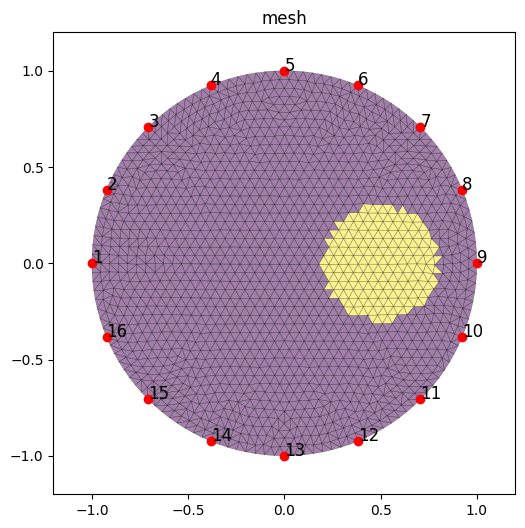

In [5]:
mesh_new = show_mesh(tmp, return_mesh=True)

## GREIT

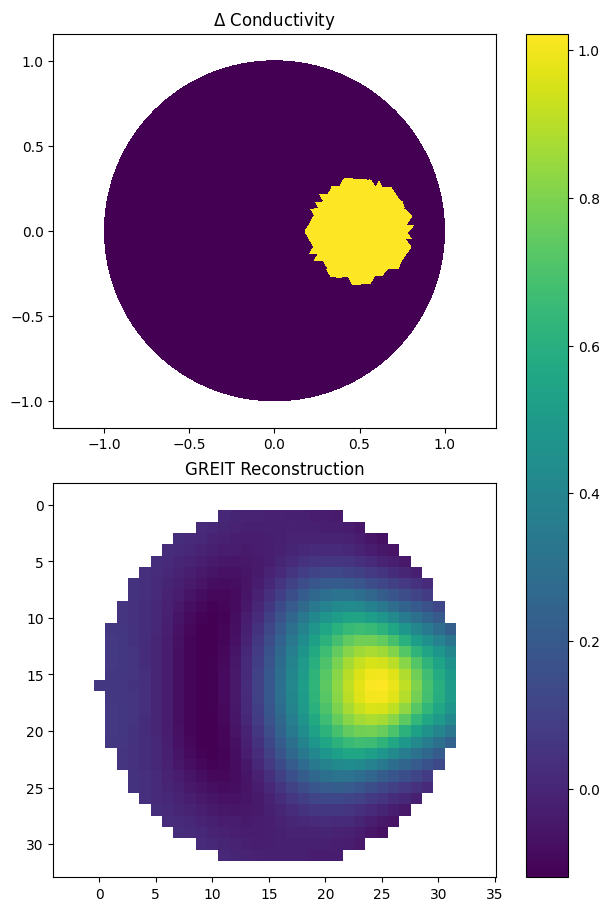

In [4]:
GREIT_sample(tmp, rec_only=False)

## JAC

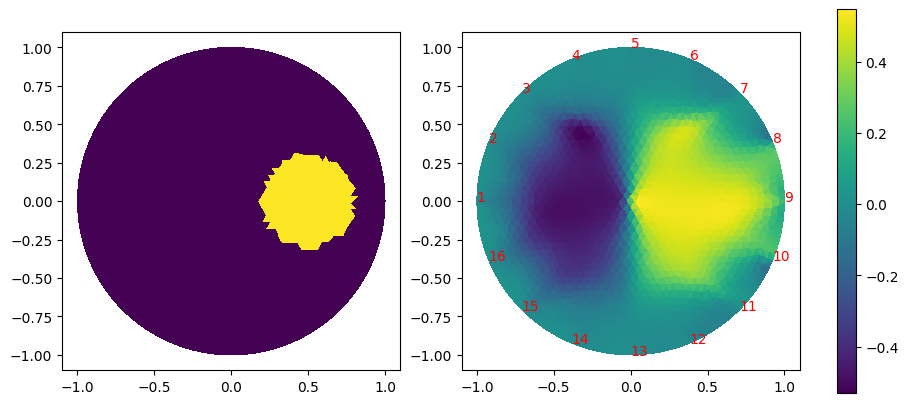

In [8]:
pts = mesh_obj.node
tri = mesh_obj.element
x, y = pts[:, 0], pts[:, 1]


eit = jac.JAC(mesh_obj, protocol_obj)
eit.setup(p=0.5, lamb=0.01, method="kotre", perm=1, jac_normalized=True)
ds = eit.solve(v1, v0, normalize=True)
ds_n = sim2pts(pts, tri, np.real(ds))

# plot ground truth
fig, axes = plt.subplots(1, 2, constrained_layout=True)
fig.set_size_inches(9, 4)

ax = axes[0]
delta_perm = mesh_new.perm - mesh_obj.perm
im = ax.tripcolor(x, y, tri, np.real(delta_perm), shading="flat")
ax.set_aspect("equal")

# plot EIT reconstruction
ax = axes[1]
im = ax.tripcolor(x, y, tri, ds_n, shading="flat")
for i, e in enumerate(mesh_obj.el_pos):
    ax.annotate(str(i + 1), xy=(x[e], y[e]), color="r")
ax.set_aspect("equal")

fig.colorbar(im, ax=axes.ravel().tolist())
# plt.savefig('../doc/images/demo_jac.png', dpi=96)
plt.show()

## BP

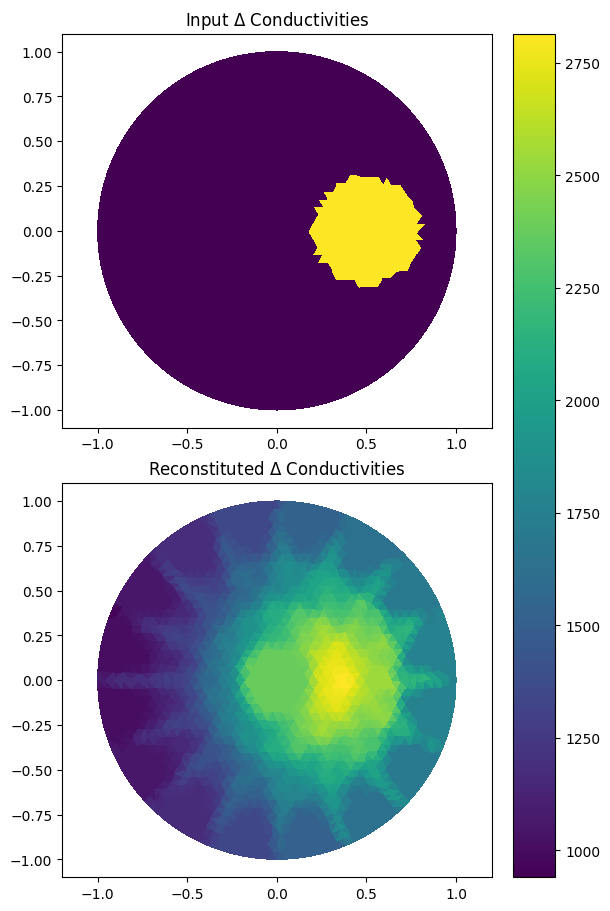

In [9]:
eit = bp.BP(mesh_obj, protocol_obj)
eit.setup(weight="none")
# the normalize for BP when dist_exc>4 should always be True
ds = 192.0 * eit.solve(v1, v0, normalize=True)

# extract node, element, alpha
pts = mesh_obj.node
tri = mesh_obj.element

# draw
fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=(6, 9))
# original
ax = axes[0]
ax.axis("equal")
ax.set_title(r"Input $\Delta$ Conductivities")
delta_perm = np.real(mesh_new.perm - mesh_obj.perm)
im = ax.tripcolor(pts[:, 0], pts[:, 1], tri, delta_perm, shading="flat")
# reconstructed
ax1 = axes[1]
im = ax1.tripcolor(pts[:, 0], pts[:, 1], tri, ds)
ax1.set_title(r"Reconstituted $\Delta$ Conductivities")
ax1.axis("equal")
fig.colorbar(im, ax=axes.ravel().tolist())
# fig.savefig('../doc/images/demo_bp.png', dpi=96)
plt.show()